In [1]:
import os
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from tqdm.auto import tqdm
from typing import Optional
from langchain_openai import OpenAIEmbeddings
import zlib
import pickle
import os

with open("./openrouter.key", "r") as f:
    os.environ["OPENROUTER_API_KEY"] = f.read().strip()
with open("./openai.key", "r") as f:
    os.environ["OPENAI_API_KEY"] = f.read().strip()

/root/miniconda3/envs/autosklearn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models = list(pd.read_excel("models.xlsx", sheet_name="Selected_Models").sort_values(by="cost_per_run")["id"])

In [7]:
import requests
base_url = "https://openrouter.ai/api/v1/parameters"

supported_params = {}

# Iterate over each model and make the API call
for model in tqdm(models):
    author, model_slug = model.split('/')
    url = f"{base_url}/{author}/{model_slug}"
    response = requests.get(url, headers={"Authorization": f"Bearer {os.environ['OPENROUTER_API_KEY']}"})

    if response.status_code == 200:
        supported_params[model] = response.json()['data']['supported_parameters']
    else:
        print(f"Failed: {model} with status code {response.status_code}")

  5%|▍         | 4/84 [00:01<00:19,  4.13it/s]

Failed: togethercomputer/stripedhyena-nous-7b with status code 404


 10%|▉         | 8/84 [00:02<00:15,  5.02it/s]

Failed: austism/chronos-hermes-13b with status code 404
Failed: qwen/qwen-110b-chat with status code 404


 15%|█▌        | 13/84 [00:03<00:15,  4.70it/s]

Failed: nousresearch/nous-hermes-yi-34b with status code 404


 18%|█▊        | 15/84 [00:03<00:12,  5.40it/s]

Failed: qwen/qwen-72b-chat with status code 404


 21%|██▏       | 18/84 [00:04<00:12,  5.28it/s]

Failed: nousresearch/hermes-2-theta-llama-3-8b with status code 404


 24%|██▍       | 20/84 [00:04<00:12,  5.20it/s]

Failed: cognitivecomputations/dolphin-llama-3-70b with status code 404


 38%|███▊      | 32/84 [00:07<00:12,  4.26it/s]

Failed: sao10k/l3-stheno-8b with status code 404


 51%|█████     | 43/84 [00:10<00:09,  4.20it/s]

Failed: openchat/openchat-8b with status code 404


 56%|█████▌    | 47/84 [00:11<00:07,  4.77it/s]

Failed: microsoft/phi-3-medium-4k-instruct with status code 404


 63%|██████▎   | 53/84 [00:13<00:08,  3.77it/s]

Failed: perplexity/llama-3-sonar-small-32k-chat with status code 404


 67%|██████▋   | 56/84 [00:14<00:06,  4.07it/s]

Failed: deepseek/deepseek-coder with status code 404


 71%|███████▏  | 60/84 [00:15<00:06,  3.99it/s]

Failed: mattshumer/reflection-70b with status code 404


 81%|████████  | 68/84 [00:17<00:03,  4.63it/s]

Failed: perplexity/llama-3-sonar-large-32k-online with status code 404


 93%|█████████▎| 78/84 [00:20<00:01,  4.36it/s]

Failed: anthropic/claude-instant-1:beta with status code 404


100%|██████████| 84/84 [00:21<00:00,  3.83it/s]


In [8]:
unique_params = set(param for params in supported_params.values() for param in params)
# sort the unique parameters by the number of models that support them
sorted_unique_params = sorted(unique_params, key=lambda x: sum(1 for model in supported_params.values() if x in model), reverse=True)
sorted_unique_params

compiled_data = [[0] * len(sorted_unique_params) for _ in range(len(supported_params))]
# Iterate over each model and add the missing parameters to the supported_params dictionary
for i, (model, params) in enumerate(supported_params.items()):
    for j, param in enumerate(sorted_unique_params):
        if param not in params:
            compiled_data[i][j] = 0
        else:
            compiled_data[i][j] = 1

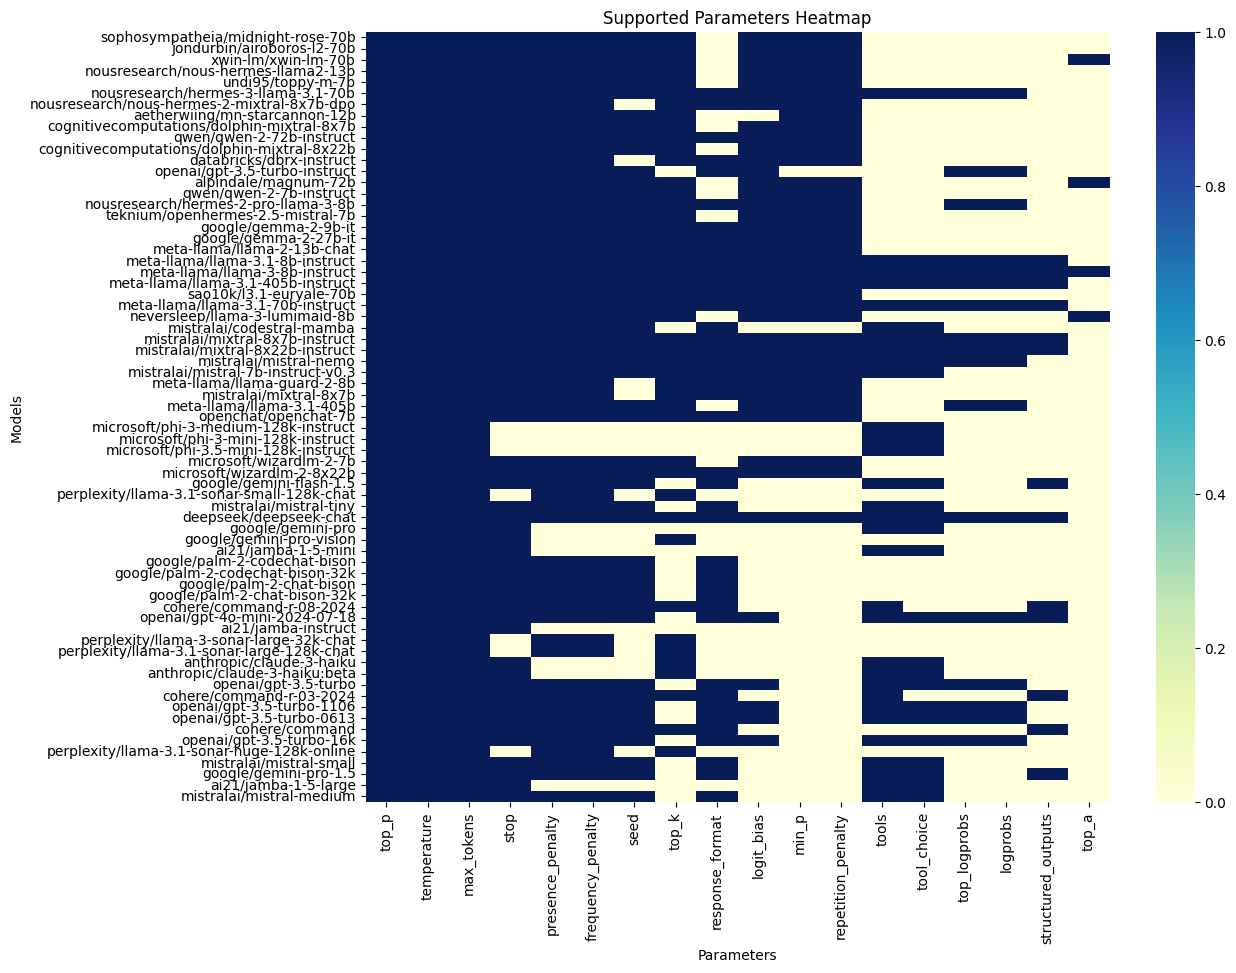

In [9]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(compiled_data, cmap="YlGnBu", cbar=True, xticklabels=sorted_unique_params, yticklabels=supported_params.keys())
plt.title("Supported Parameters Heatmap")
plt.xlabel("Parameters")
plt.ylabel("Models")
plt.show()

In [10]:
selected_params = ['temperature', 'top_p', 'top_k', 'frequency_penalty']
selected_models = [model for model, params in supported_params.items() if all(param in params for param in selected_params)]
selected_models

['sophosympatheia/midnight-rose-70b',
 'jondurbin/airoboros-l2-70b',
 'xwin-lm/xwin-lm-70b',
 'nousresearch/nous-hermes-llama2-13b',
 'undi95/toppy-m-7b',
 'nousresearch/hermes-3-llama-3.1-70b',
 'nousresearch/nous-hermes-2-mixtral-8x7b-dpo',
 'aetherwiing/mn-starcannon-12b',
 'cognitivecomputations/dolphin-mixtral-8x7b',
 'qwen/qwen-2-72b-instruct',
 'cognitivecomputations/dolphin-mixtral-8x22b',
 'databricks/dbrx-instruct',
 'alpindale/magnum-72b',
 'qwen/qwen-2-7b-instruct',
 'nousresearch/hermes-2-pro-llama-3-8b',
 'teknium/openhermes-2.5-mistral-7b',
 'google/gemma-2-9b-it',
 'google/gemma-2-27b-it',
 'meta-llama/llama-2-13b-chat',
 'meta-llama/llama-3.1-8b-instruct',
 'meta-llama/llama-3-8b-instruct',
 'meta-llama/llama-3.1-405b-instruct',
 'sao10k/l3.1-euryale-70b',
 'meta-llama/llama-3.1-70b-instruct',
 'neversleep/llama-3-lumimaid-8b',
 'mistralai/mixtral-8x7b-instruct',
 'mistralai/mixtral-8x22b-instruct',
 'mistralai/mistral-nemo',
 'mistralai/mistral-7b-instruct-v0.3',
 'me

In [3]:
class ChatOpenRouter(ChatOpenAI):
    openai_api_base: str
    openai_api_key: str
    model_name: str
    top_p: Optional[float]
    top_k: Optional[int]
    frequency_penalty: Optional[float]

    def __init__(self,
                 model: str,
                 openai_api_key: Optional[str] = None,
                 openai_api_base: str = "https://openrouter.ai/api/v1",
                 top_p: Optional[float] = None,
                 top_k: Optional[int] = None,
                 frequency_penalty: Optional[float] = None,
                 **kwargs):
        openai_api_key = openai_api_key or os.getenv('OPENROUTER_API_KEY')
        super().__init__(openai_api_base=openai_api_base,
                         openai_api_key=openai_api_key,
                         model_name=model,
                         top_p=top_p, 
                         top_k=top_k,
                         frequency_penalty=frequency_penalty, **kwargs)

gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{prompt}"),
    ]
)

ROUNDS = 1
dataset = "revised_dataset"
df = pd.read_feather(f"./datasets/{dataset}.feather")

with open("./classification_models/best.pkl.zlib", "rb") as f:
    compressed = f.read()
    automl = pickle.loads(zlib.decompress(compressed))
    print(automl)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

def generate_predictions(model, model_name, temperature, top_p, top_k, frequency_penalty):
    gen_llm = ChatOpenRouter(
        model = model,
        cache=False,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        frequency_penalty=frequency_penalty,
        seed=42,
        max_tokens=10000
    )
    generator = gen_prompt | gen_llm
    gens = []
    prompts = []
    
    for index, output in tqdm(generator.batch_as_completed(list(df["Prompt"]), return_exceptions=True), total=len(df)):
        try:
            gens.append(output.content)
            prompts.append(list(df["Prompt"])[index])            
        except Exception as e:
            print(output)
            # print(f"Error occurred: {str(e)}")
            continue
    # print(f"Generated {len(gens)} samples")
    emb = embeddings.embed_documents([x + " " + y for x,y in zip(prompts, gens)])
    # print(f"Embedded {len(emb)} samples")
    pred = automl.predict(emb)
    score = len(list(filter(lambda x: x == "A" or x == "W", pred)))/ len(pred)
    # output prompt and generated text to text file
    with open(f"./results/optuna/{model_name}.txt", "a") as f:
        f.write(f"Model: {model_name}\n")
        f.write(f"Temperature: {temperature}\n")
        f.write(f"Top P: {top_p}\n")
        f.write(f"Top K: {top_k}\n")
        f.write(f"Frequency Penalty: {frequency_penalty}\n\n")
        for i in range(len(prompts)):
            f.write(f"Prompt: {prompts[i]}\n")
            f.write(f"Generated: {gens[i]}\n\n")
    return score

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=16384, n_jobs=-1, per_run_time_limit=20,
                      time_left_for_this_task=240)


In [4]:
import optuna

# Define the objective function
def objective(trial, model):
    # Suggest values for the selected parameters
    temperature = trial.suggest_float('temperature', 0.0, 1.0)
    top_p = trial.suggest_float('top_p', 0.0, 1.0)
    top_k = trial.suggest_int('top_k', 1, 100)
    frequency_penalty = trial.suggest_float('frequency_penalty', 0, 2.0)
    
    # Here you would use these parameters to run your model and get the performance metric
    model_name = model.replace("/", "_")
    performance_metric = generate_predictions(model, model_name, temperature, top_p, top_k, frequency_penalty)
    
    return performance_metric

# for model in selected_models:
for model in [
    "undi95/toppy-m-7b",
    "google/gemma-2-9b-it",
    "neversleep/llama-3-lumimaid-8b",
    "qwen/qwen-2-7b-instruct",
    "microsoft/wizardlm-2-7b",
    "openchat/openchat-7b",
    "nousresearch/nous-hermes-llama2-13b",
    "meta-llama/llama-3-8b-instruct",
    "meta-llama/llama-3.1-8b-instruct",
    "mistralai/mistral-7b-instruct-v0.3",
    "teknium/openhermes-2.5-mistral-7b"
]:
    model_name = model.replace("/", "_")
    trials = 10
    print(model_name)
    if os.path.exists(f"./results/optuna/{model_name}_{trials}.pkl"):
        continue
    
    study = optuna.create_study(direction='maximize', study_name='openrouter_study')
    study.optimize(lambda trial: objective(trial, model), n_trials=trials)

    # Print the best parameters
    print("Best parameters: ", study.best_params)
    print("Best value: ", study.best_value)
    
    pickle.dump(study, open(f"./results/optuna/{model_name}_{trials}.pkl", "wb"))

[I 2025-02-24 13:56:48,469] A new study created in memory with name: openrouter_study


nousresearch_nous-hermes-llama2-13b


100%|██████████| 509/509 [08:09<00:00,  1.04it/s]
[I 2025-02-24 14:05:08,042] Trial 0 finished with value: 0.7858546168958742 and parameters: {'temperature': 0.3075901083583332, 'top_p': 0.8550115819678423, 'top_k': 20, 'frequency_penalty': 1.2714149109814292}. Best is trial 0 with value: 0.7858546168958742.
100%|██████████| 509/509 [12:09<00:00,  1.43s/it]
[I 2025-02-24 14:17:26,503] Trial 1 finished with value: 0.8015717092337917 and parameters: {'temperature': 0.2968623764263302, 'top_p': 0.7874819651653472, 'top_k': 46, 'frequency_penalty': 0.028777065119610645}. Best is trial 1 with value: 0.8015717092337917.
100%|██████████| 509/509 [07:50<00:00,  1.08it/s]
[I 2025-02-24 14:25:24,903] Trial 2 finished with value: 0.7642436149312377 and parameters: {'temperature': 0.9922039387004665, 'top_p': 0.0809044399534079, 'top_k': 35, 'frequency_penalty': 1.7366187466973866}. Best is trial 1 with value: 0.8015717092337917.
100%|██████████| 509/509 [07:32<00:00,  1.13it/s]
[I 2025-02-24 14:3

Best parameters:  {'temperature': 0.2968623764263302, 'top_p': 0.7874819651653472, 'top_k': 46, 'frequency_penalty': 0.028777065119610645}
Best value:  0.8015717092337917


In [5]:
import optuna.visualization as vis

studies = []

for file in os.listdir("./results/optuna"):
    if file.endswith(".pkl"):
        study = pickle.load(open(f"./results/optuna/{file}", "rb"))
        study.study_name = "/".join("".join(file.split(".")[:-1]).split("_")[:-1])
        print(study.study_name)
        studies.append(study)

undi95/toppy-m-7b
google/gemma-2-9b-it
neversleep/llama-3-lumimaid-8b
meta-llama/llama-3-8b-instruct
microsoft/wizardlm-2-7b
openchat/openchat-7b
nousresearch/nous-hermes-llama2-13b
meta-llama/llama-31-8b-instruct
mistralai/mistral-7b-instruct-v03
teknium/openhermes-25-mistral-7b


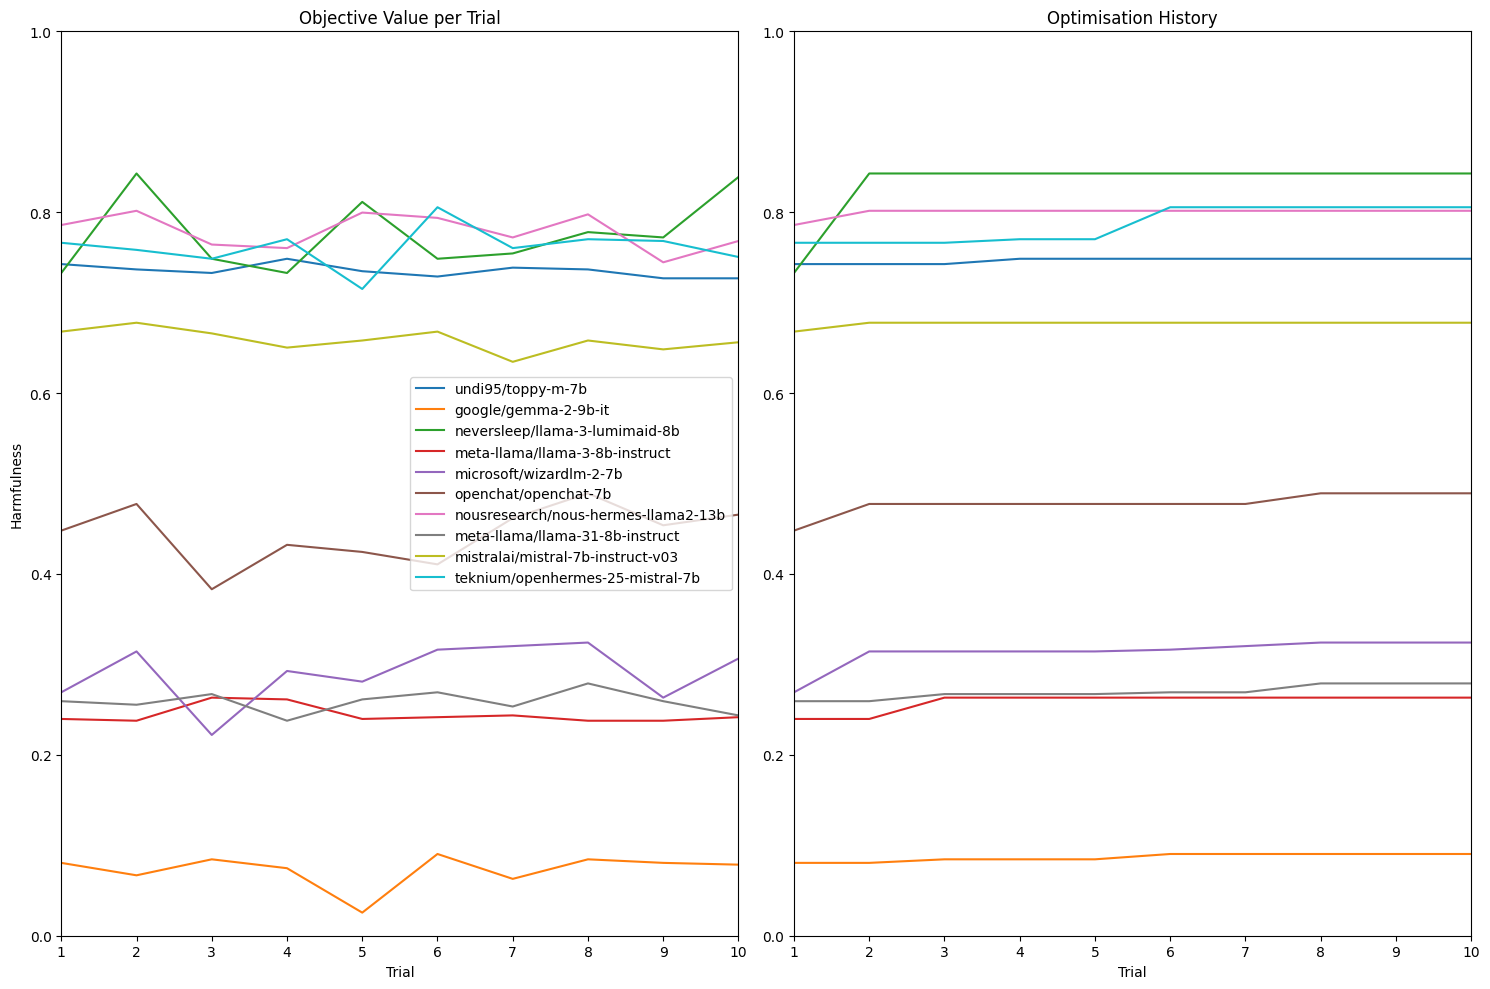

<Figure size 600x800 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [1, 1]})

values = {s.study_name :s.trials_dataframe()['value'].to_list() for s in studies}
for k, v in values.items():
    sns.lineplot(x=range(1,len(v)+1), y=v, label=k, ax=axes[0])

axes[0].set_title("Objective Value per Trial")
axes[0].set_xlabel("Trial")
axes[0].set_xlim(1, 10)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Harmfulness")

plt.figure(figsize=(6,8))

for k, v in values.items():
    for i in range(1, len(v)):
        v[i] = max(v[i], v[i-1])
    sns.lineplot(x=range(1,len(v)+1), y=v, label=k,ax=axes[1], legend=False)

axes[1].set_title("Optimisation History")
axes[1].set_xlabel("Trial")
axes[1].set_xlim(1, 10)
axes[1].set_ylim(0, 1)
# axes[1].set_ylabel("Harmfulness")

fig.tight_layout()
fig.savefig("./plots/optimisation_trials.pdf")
# plt.show()

Text(0, 0.5, 'Importance')

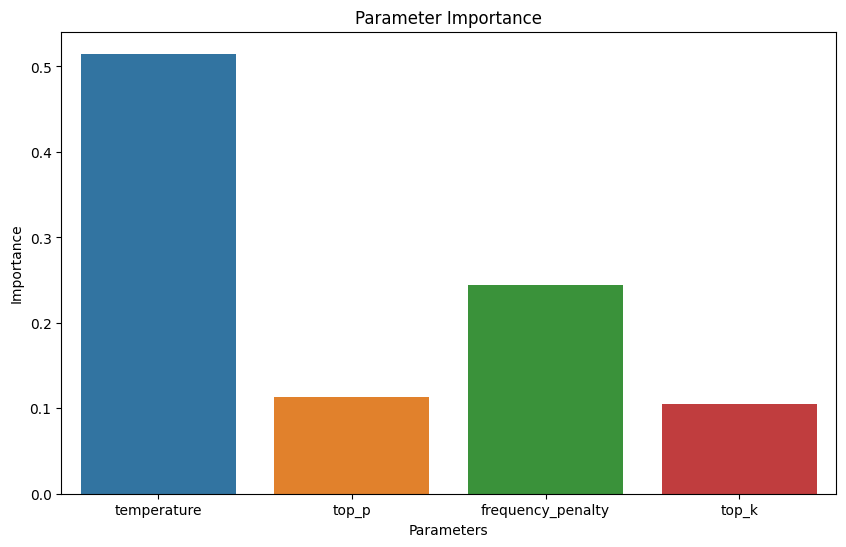

In [46]:
import optuna.importance as imp
importances = {'temperature': 0, 'top_p': 0, 'frequency_penalty': 0, 'top_k': 0}

for s in studies:
    importances = {k: importances.get(k, 0) + imp.get_param_importances(s).get(k, 0) for k in importances | imp.get_param_importances(s)} 
importances = importances | {k: v/len(studies) for k, v in importances.items()}

# plot the importances
plt.figure(figsize=(10, 6))
sns.barplot(x=list(importances.keys()), y=list(importances.values()))
plt.title("Parameter Importance")
plt.xlabel("Parameters")
plt.ylabel("Importance")
